### Previsão de preços
#### Período de análise: Janeiro de 2010 até Março de 2021.
##### Autor: Saulo Brendo Alves de Jesus 
##### LinkedIn: linkedin.com/in/saulo-brendo/

### Bibliotecas

In [1]:
# Bibliotecas utilizadas
import pandas as pd
from pandas_datareader import data
import numpy as np
import seaborn as sns
import statsmodels.tsa.stattools as ts 
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

### Importação de dados

In [2]:
# Definir ativo
ticker = "^BVSP"

# Definindo período
init_data = '1/1/2010'
end_data = "31/03/2021"

# Solicitação de dados através da API
dados_ativo = data.DataReader(ticker,'yahoo',init_data,end_data)

# Remover coluna Close
del dados_ativo["Close"]

dados_ativo.head()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2010-01-04,70081.0,68587.0,68587.0,1655400.0,70045.0
2010-01-05,70595.0,69928.0,70046.0,1984200.0,70240.0
2010-01-06,70937.0,70016.0,70237.0,2243600.0,70729.0
2010-01-07,70723.0,70045.0,70723.0,1555000.0,70451.0
2010-01-08,70766.0,70158.0,70455.0,1634400.0,70263.0


### Tratamento

In [3]:
# Transformar dados diários em semanais
dados_ativo = dados_ativo.asfreq('W-FRI', method='pad')
dados_ativo.head()

,High,Low,Open,Volume,Adj Close
Date,,,,,
2010-01-08,70766.0,70158.0,70455.0,1634400.0,70263.0
2010-01-15,69788.0,68695.0,69780.0,1648400.0,68978.0
2010-01-22,66660.0,65445.0,66264.0,1305000.0,66220.0
2010-01-29,66576.0,65140.0,65591.0,1823200.0,65402.0
2010-02-05,64001.0,61341.0,63934.0,3053000.0,62763.0


In [4]:
# Copiar coluna data 
dados_ativo["Date"] = dados_ativo.index
dados_ativo.head()

,High,Low,Open,Volume,Adj Close,Date
Date,,,,,,
2010-01-08,70766.0,70158.0,70455.0,1634400.0,70263.0,2010-01-08
2010-01-15,69788.0,68695.0,69780.0,1648400.0,68978.0,2010-01-15
2010-01-22,66660.0,65445.0,66264.0,1305000.0,66220.0,2010-01-22
2010-01-29,66576.0,65140.0,65591.0,1823200.0,65402.0,2010-01-29
2010-02-05,64001.0,61341.0,63934.0,3053000.0,62763.0,2010-02-05


In [5]:
# Verificar informações sobre os ativos
dados_ativo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 586 entries, 2010-01-08 to 2021-03-26
Freq: W-FRI
Data columns (total 6 columns):
High         586 non-null float64
Low          586 non-null float64
Open         586 non-null float64
Volume       586 non-null float64
Adj Close    586 non-null float64
Date         586 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(5)
memory usage: 32.0 KB


In [6]:
# Definir valor das Médias Móveis rápida e lenta
FastMA = 5
SlowMA = 15

# Criar coluna com os valores das Médias Móveis
dados_ativo['Fast MA'] = np.round(dados_ativo['Adj Close'].rolling(window=FastMA).mean(),2)
dados_ativo['Slow MA'] = np.round(dados_ativo['Adj Close'].rolling(window=SlowMA).mean(),2)

# Shifitar dados
dados_ativo['Adj Close'] = dados_ativo['Adj Close'].shift(-1)
dados_ativo.tail()

# Remover NA's
dados_ativo = dados_ativo.dropna()

dados_ativo.tail()

,High,Low,Open,Volume,Adj Close,Date,Fast MA,Slow MA
Date,,,,,,,,
2021-02-19,119250.0,117867.0,119199.0,10402800.0,110035.0,2021-02-19,118193.6,116133.20
2021-02-26,113466.0,109827.0,112260.0,14618500.0,115202.0,2021-02-26,116766.2,116501.40
2021-03-05,115504.0,112504.0,112690.0,13254800.0,114160.0,2021-03-05,116605.2,117080.40
2021-03-12,114984.0,113253.0,114984.0,8110700.0,116222.0,2021-03-12,115452.2,117319.40
2021-03-19,116446.0,114610.0,114837.0,12341800.0,114781.0,2021-03-19,114873.4,117488.73


In [7]:
# Separar dados
linhas_total = len(dados_ativo)
linhas_treino = linhas_total - 300
linhas_teste = linhas_total - 15
linhas_valid = linhas_treino - linhas_teste

info = (
    f"Treino = 0:{linhas_treino}"
    f" Teste = {linhas_treino}:{linhas_teste}"
    f" Validação = {linhas_teste}:{linhas_total}"
)

info

'Treino = 0:271 Teste = 271:556 Validação = 556:571'

In [8]:
# Alterar Índice
dados_ativo = dados_ativo.reset_index(drop = True)
dados_ativo.head()

,High,Low,Open,Volume,Adj Close,Date,Fast MA,Slow MA
0,70522.0,69013.0,70522.0,2043800.0,69509.0,2010-04-16,69897.2,68083.67
1,69709.0,68832.0,69388.0,1366800.0,67530.0,2010-04-23,70033.2,68033.40
2,67975.0,67243.0,67975.0,2120200.0,62871.0,2010-04-30,69802.6,67936.87
3,63945.0,61663.0,63416.0,2903400.0,63412.0,2010-05-07,68149.6,67713.60
4,64787.0,63050.0,64787.0,2220800.0,60259.0,2010-05-14,66548.6,67580.93


### Modelagem

In [9]:
# Features e Labels
features = dados_ativo.drop(["Adj Close", "Date"], 1)
labels = dados_ativo["Adj Close"]

In [10]:
# Seleção das melhores Features utilizando Kbest
features_list = ("High", "Low", "Open","Volume", "Fast MA", "Slow MA")

# Kbest Model
kbest_features = SelectKBest(k = 'all')
kbest_features.fit_transform(features, labels)
kbest_features_scores = kbest_features.scores_

# União e Ordenação
raw_pairs = zip(features_list[1:], kbest_features_scores)
order_pairs = list(reversed(sorted(raw_pairs, key = lambda x: x[1])))

kbest_features_final = dict(order_pairs[:15])
best_features = kbest_features_final.keys()
print("")
print("Best Features: ")
print(kbest_features_final)


Best Features: 
{'Low': 82.86439592581526, 'Volume': 82.27522702823238, 'Open': 82.01373093330949, 'Slow MA': 50.2756468225931, 'Fast MA': 0.1868634483840172}


In [11]:
# Remoção de Features indesejadas
features = dados_ativo.drop(["Adj Close", "Date", "Fast MA"], 1)

In [12]:
# Normalização de entradas

# Geração de novo padrão
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print("Features: ", features_scale.shape)
print(features_scale)

Features:  (571, 5)
[[0.36922192 0.36947867 0.38239925 0.12348573 0.34142094]
 [0.35986418 0.36734043 0.36917245 0.08258161 0.34075083]
 [0.33990562 0.3485688  0.35269143 0.1281018  0.33946407]
 ...
 [0.88697053 0.88325911 0.87424039 0.80085071 0.99455688]
 [0.88098527 0.89210741 0.90099726 0.49004586 0.9977428 ]
 [0.89781308 0.90813831 0.89928267 0.74568755 1.        ]]


In [13]:
# Separar dados de treino, teste e validação
x_treino = features_scale[:linhas_treino]
x_teste = features_scale[linhas_treino:linhas_teste]

y_treino = labels[:linhas_treino]
y_teste = labels[linhas_treino:linhas_teste]

print(len(x_treino), len(y_treino))
print(len(x_teste), len(y_teste))

271 271
285 285


In [14]:
# Regressão Linear
lr = linear_model.LinearRegression()
lr.fit(x_treino, y_treino)
predict = lr.predict(x_teste)
cd = r2_score(y_teste, predict)

f"Coeficiente de Determinação:{cd * 100:.2f}"

'Coeficiente de Determinação:97.89'

### Previsão

In [15]:
# Previsão com Regressão Linear

prevision = features_scale[linhas_teste:linhas_total]

data_total = dados_ativo["Date"]
data = data_total[linhas_teste:linhas_total]

price_real = dados_ativo["Adj Close"]
price = price_real[linhas_teste:linhas_total]

predict = lr.predict(prevision)

# DataFrame com valores de preço real e preço predito
df = pd.DataFrame({'Data':data,
                   'Real Price':price, 'Pred Price':predict})

df.set_index('Data', inplace = True)

df.head()

,Real Price,Pred Price
Data,,
2020-12-11,117679.0,112145.039846
2020-12-18,117857.0,116057.588083
2020-12-25,119306.0,115458.781951
2021-01-01,125077.0,116833.886365
2021-01-08,120502.0,122221.066485


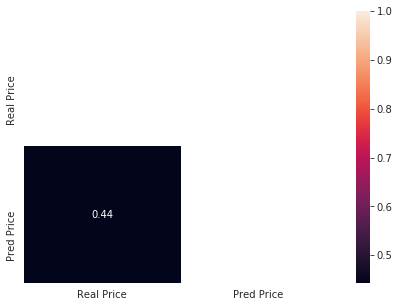

In [16]:
# Correlação
corr = df.corr()

# Criar mascara para visualizar apenas uma das partes
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plotar gráfico de correlação
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, annot=True)

/home/lbs/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


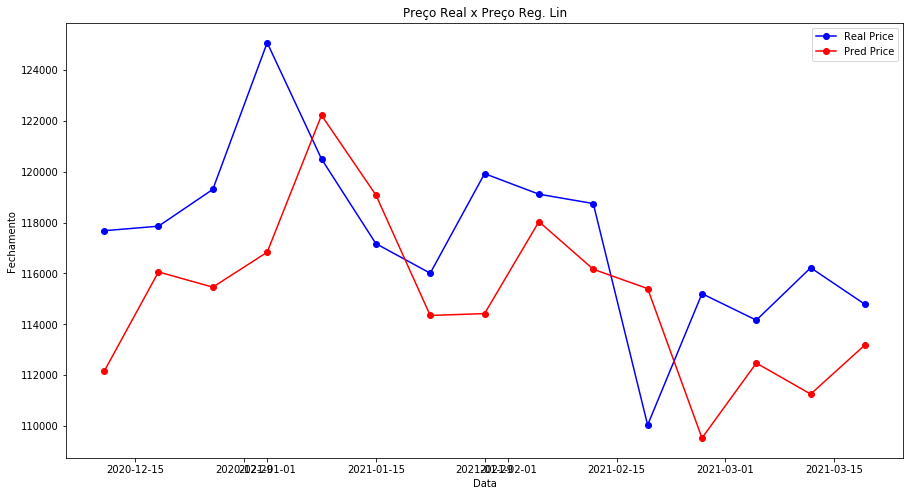

In [17]:
# Plot Gráfico
plt.figure(figsize = (15,8))
plt.title("Preço Real x Preço Reg. Lin")
plt.plot(df['Real Price'], label = 'Real Price',
         color = 'blue', marker = 'o')
plt.plot(df['Pred Price'], label = 'Pred Price', 
        color = 'red', marker = 'o')
plt.xlabel('Data')
plt.ylabel('Fechamento')
leg = plt.legend()